Объявление нужных нам модулей, классов, методов.

In [1]:
from typing import Tuple, Any
import random
import os

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import torch
import cv2

Разделение загруженного набора на обучающую, тестовую и валидационную выборки.

In [ ]:
PATH = "/content/drive/MyDrive/Colab Notebooks/"
main_df = pd.read_csv(PATH+"ML.csv", header=None, sep=";")

learn_frames = [main_df[:800], main_df[1031:1831]]
learn_df = pd.concat(learn_frames)
learn_df

test_frames = [main_df[800:900], main_df[1831:1931]]
test_df = pd.concat(test_frames)
test_df

valid_frames = [main_df[900:1000], main_df[1931:2031]]
valid_df = pd.concat(valid_frames)
valid_df

learn_df.to_csv(PATH+"ML_learn.csv", sep=";", index=None, header=None)
test_df.to_csv(PATH+"ML_test.csv", sep=";", index=None, header=None)
valid_df.to_csv(PATH+"ML_valid.csv", sep=";", index=None, header=None)

Свёрточная нейронная сеть для решения задач классификации.

In [111]:
class CNN(torch.nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()
        
        self.conv_1 = torch.nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2)
        self.conv_2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2)
        self.conv_3 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2)

        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.1)
        self.max_pool = torch.nn.MaxPool2d(2)
        
        self.fc_1 = torch.nn.Linear(576, 10)
        self.fc_2 = torch.nn.Linear(10, 1)
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        output = self.relu(self.conv_1(x))
        output = self.max_pool(output)
        output = self.relu(self.conv_2(output))
        output = self.max_pool(output)
        output = self.relu(self.conv_3(output))
        output = self.max_pool(output)
        
        output = torch.nn.Flatten()(output)
        output = self.relu(self.fc_1(output))
        output = torch.nn.Sigmoid()(self.fc_2(output))
        return output

Описание пайплайна предобработки данных.

In [112]:
custom_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Resize((224, 224)), 
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

Класс для работы с набором данных.

In [113]:
class CustomImageDataset(Dataset):
  def __init__(self, path_to_annotation_file: str, transform: Any=None, target_transform: Any=None) -> None:
    self.path_to_annotation_file = path_to_annotation_file
    self.dataset_info = pd.read_csv(path_to_annotation_file, sep=";", header=None)
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self) -> int:
    return len(self.dataset_info)

  def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
    path_to_image = self.dataset_info.iloc[index, 0]
    image = cv2.cvtColor(cv2.imread(path_to_image), cv2.COLOR_BGR2RGB)
    label = self.dataset_info.iloc[index, 1]

    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_Transform(label)
      
    return image, label

Train Loop(цикл обучения)

In [114]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = CNN().to(device)

In [115]:
learn_annotation = r"/content/drive/MyDrive/Colab Notebooks/ML_learn.csv"
test_annotation = r"/content/drive/MyDrive/Colab Notebooks/ML_test.csv"
valid_annotation = r"/content/drive/MyDrive/Colab Notebooks/ML_valid.csv"

learn_dataset = CustomImageDataset(learn_annotation, custom_transforms)
test_dataset = CustomImageDataset(test_annotation, custom_transforms)
valid_dataset = CustomImageDataset(valid_annotation, custom_transforms)

learn_dataloader = DataLoader(learn_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=True)

In [ ]:
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

epochs = 10
n = 0
accuracy_values = []
loss_values = []
val_loss_values = []
val_accuracy_values = []

while(n < epochs):

    epoch_loss = 0
    epoch_accuracy = 0
    model.train()
    
    for data, label in learn_dataloader:
        data = data.to(device)
        label = label.to(device)
 
        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(2)])).mean()
        epoch_accuracy += acc / len(learn_dataloader)
        epoch_loss += loss / len(learn_dataloader)

    print(epoch_accuracy, epoch_loss.item())
    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)

    model.eval()
    valid_loss = 0
    valid_accuracy = 0
    
    for data, label in valid_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)

        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(2)])).mean()
        valid_accuracy += acc / len(valid_dataloader)
        valid_loss += float(loss.detach()) / len(valid_dataloader)

    val_loss_values.append(valid_loss)
    val_accuracy_values.append(valid_accuracy)
    print(valid_accuracy, valid_loss, end="\n\n")
    n += 1

Графики для значения функции потерь и выбранной метрики качества для обучающей и валидационной выборок.

In [ ]:
a = 1
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(1, 4, 1)
plt.title('Plots for learn(Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.plot(range(10), accuracy_values, color="red")
plt.legend(loc=2, prop={'size': 20})

fig.add_subplot(1, 4, 2)
plt.title('Plots for learn(Loss)')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.plot(range(10), [float(value.detach()) for value in loss_values], color="green")
plt.legend(loc=2, prop={'size': 20})

fig.add_subplot(1, 4, 3)
plt.title('Plots for valid(Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.plot(range(10), val_accuracy_values, color="blue")
plt.legend(loc=2, prop={'size': 20})

fig.add_subplot(1, 4, 4)
plt.title('Plots for valid(Loss)')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.plot(range(10), val_loss_values, color="purple")
plt.legend(loc=2, prop={'size': 20})

plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/plots/experiment_{a}")

Оценка качества работы модели на тестовой выборке.

In [ ]:
model.eval()

test_loss = 0
test_accuracy = 0
    
for data, label in test_dataloader:
    data = data.to(device)
    label = label.to(device)

    output = model(data)
    
    acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(2)])).mean()
    test_accuracy += acc / len(test_dataloader)
    test_loss += float(loss.detach()) / len(test_dataloader)

test_accuracy, test_loss

(0.7450000000000003, 0.004033498931676149)

Сохранение нашей модели.

In [ ]:
path_to_model = r"/content/drive/MyDrive/Colab Notebooks/Model.pth"
torch.save(model.state_dict(), path_to_model)

Выгрузка модели и демонстрация её работы.

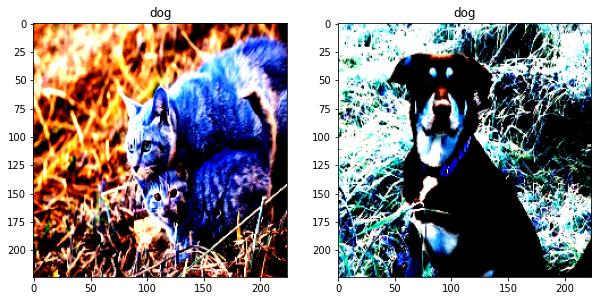

In [106]:
loaded_model = CNN().to(device)
loaded_model.load_state_dict(torch.load(path_to_model))
loaded_model.eval()

plt.figure(figsize=(10, 5))

for j in range(2):
  index = random.randint(0, 200)
  plt.subplot(1, 2, j + 1)
  plt.title("cat" if (0 if  loaded_model(test_dataset[index][0].unsqueeze(dim=0))[0] < 0.5 else 1) == 0 else "dog")
  plt.imshow(test_dataset[index][0].permute(1, 2, 0).numpy()[:, :, ::-1])